In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import pytz
from collections import Counter

data_dir = '../../data/'

In [14]:
data = pd.read_csv(data_dir + 'concat/MWRA_TA_DIC_2017_to_2022.csv'
                   , parse_dates=['PROF_DATE_TIME_LOCAL'])

# convert the data column to a value that can be used for machine learning
data['PROF_DATE_TIME_LOCAL'] = pd.to_datetime(data['PROF_DATE_TIME_LOCAL'], utc=True)
data['year'] = data['PROF_DATE_TIME_LOCAL'].dt.year
data['month'] = data['PROF_DATE_TIME_LOCAL'].dt.month
data['day'] = data['PROF_DATE_TIME_LOCAL'].dt.day

# Remove any rows with missing data (CC/HAR/NFAL is removed)
data = data[(data['LATITUDE'].notnull())
            & (data['LONGITUDE'].notnull())
            & (data['PROF_DATE_TIME_LOCAL'].notnull())
            & (data['DEPTH (m)'].notnull())]

# Remove HAR
data = data[data['STAT_ID'] != 'HAR']


# Remove a station for validation
# N18
val_stat = 'N18'
n18 = data[data['STAT_ID'] == val_stat]

# Split the data into hifi an lofi without the validation station
ta = data[(data['TA in (mmol/kgSW)'].notnull()) & (data['STAT_ID'] != val_stat)]
print(Counter(ta['STAT_ID']))
# Print the date range for every station in the data
#for station in ta['STAT_ID'].unique():
    #print(station, ta[ta['STAT_ID'] == station]['PROF_DATE_TIME_LOCAL'].min(),
          #ta[ta['STAT_ID'] == station]['PROF_DATE_TIME_LOCAL'].max())
          
sal = data[(data['SAL (PSU)'].notnull()) & (data['STAT_ID'] != val_stat)]

Counter({'F22': 91, 'N01': 65, 'F06': 51, 'N07': 51, 'SG1': 29, 'N04': 18, 'F23': 18, 'M2': 12, 'C2': 12, 'H2': 11, '124': 9, 'H4': 6, '139': 6, '141': 6, '38': 4, 'F13': 3, 'SN12': 3, 'SC2': 3, 'SC03': 3, 'SG Buoy': 3, 'SN16': 2, 'SN15': 2, 'SN13': 2, 'SN08': 2, 'SC1': 2, 'SC10': 2, 'SC09': 2, 'SC07': 2, 'SN01': 1, 'SN03': 1, 'SN14': 1, 'SN04': 1, 'SN05': 1, 'SN06': 1, 'SN11': 1, 'SN07': 1, 'SN10': 1, 'SN09': 1, 'SC14': 1, 'SC13': 1, 'SC12': 1, 'SC04': 1, 'SC11': 1, 'SC05': 1, 'SC06': 1, 'SC08': 1, 'SS03': 1, 'SS02': 1})


In [15]:
len(ta)

440

In [6]:
ta[ta['PROF_DATE_TIME_LOCAL'] > datetime(2020, 1, 1, 0, 0, tzinfo=pytz.UTC)]['STAT_ID'].unique()

array(['F06', 'N07', 'F22', 'N01', 'HAR'], dtype=object)

# Multifidelity modeling of Total Alkalinity

## Low Fidelity Data
Hunt 2021: Gulf of Maine Historical Relationship
TA(micro mol/kg) = SAL(g/kg) * 47.6 + 643

<img src="hunt2021.jpg" alt="drawing" width="300"/>

In [8]:
def ta_from_sal(sal):
    return 47.6 * sal + 643

In [9]:
predicted_ta = ta_from_sal(sal['SAL (PSU)'])

In [10]:
lofi_pos = sal[['LATITUDE', 'LONGITUDE', 'year', 'month', 'day', 'DEPTH (m)']].values
lofi_ta = predicted_ta.values

## High Fidelity Data
MWRA data

In [11]:
hifi_pos = ta[['LATITUDE', 'LONGITUDE', 'year', 'month', 'day', 'DEPTH (m)']].values
hifi_ta = ta['TA in (mmol/kgSW)'].values

### Correlation between low and high fidelity data

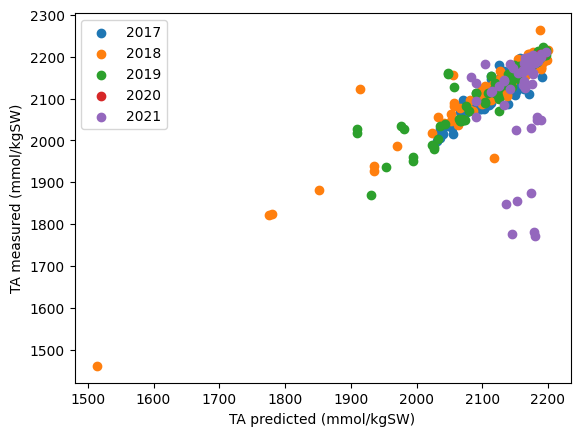

In [12]:
# use the lofi model to predict TA from salinity in a new column
predicted_ta = ta['SAL (PSU)'].apply(ta_from_sal)

# Plot the lofi model against the hifi data
# PLot each year of data with a different color
for year in range(2017, 2022):
    plt.scatter(predicted_ta[ta['year'] == year], ta['TA in (mmol/kgSW)'][ta['year'] == year], label=year)
plt.xlabel('TA predicted (mmol/kgSW)')
plt.ylabel('TA measured (mmol/kgSW)')
plt.legend()

#plt.scatter(predicted_ta, ta['TA in (mmol/kgSW)'])
#plt.xlabel('TA predicted (mmol/kgSW)')
#plt.ylabel('TA measured (mmol/kgSW)')

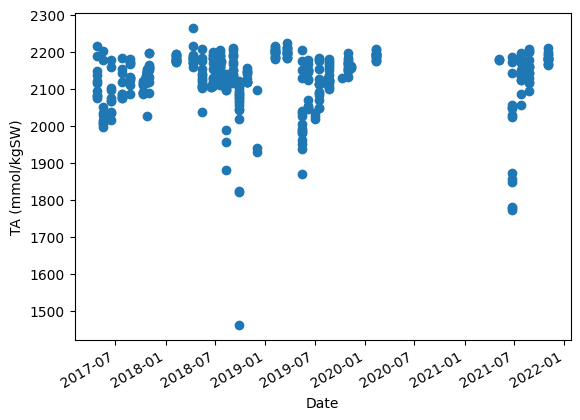

In [33]:
# Plot total alkalinity vs time
plt.scatter(ta['PROF_DATE_TIME_LOCAL'], ta['TA in (mmol/kgSW)'])
# Make the x axis a date
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('TA (mmol/kgSW)')
plt.show()

## Exact GP with fidelities combined

In [35]:
import math
import torch
import tqdm
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

from gpytorch.models import ExactGP
from gpytorch.kernels import ScaleKernel, RBFKernel, PeriodicKernel
from gpytorch.means import ConstantMean

In [36]:
# Combine lofi_pos and hifi_pos into a single array
pos = np.concatenate((lofi_pos, hifi_pos))
#pos = hifi_pos

# Combine lofi_ta and hifi_ta into a single array
ta = np.concatenate((lofi_ta, hifi_ta))
#ta = hifi_ta

In [37]:
train_x = torch.from_numpy(pos).float()
train_y = torch.from_numpy(ta).float()

train_x.shape, train_y.shape

(torch.Size([4054, 6]), torch.Size([4054]))

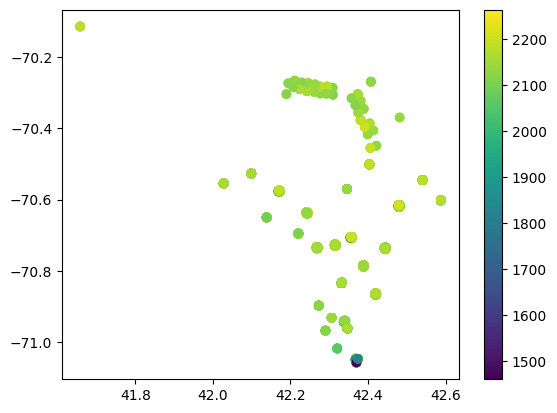

In [38]:
# Plot the 3d x values vs the 1d y values
plt.scatter(train_x[:, 0], train_x[:, 1], c=train_y)
plt.colorbar()

In [39]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = ScaleKernel(PeriodicKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Training

In [40]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [ ]:
training_iter = 200
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.32)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

# Validation using station N18

<AxesSubplot:>

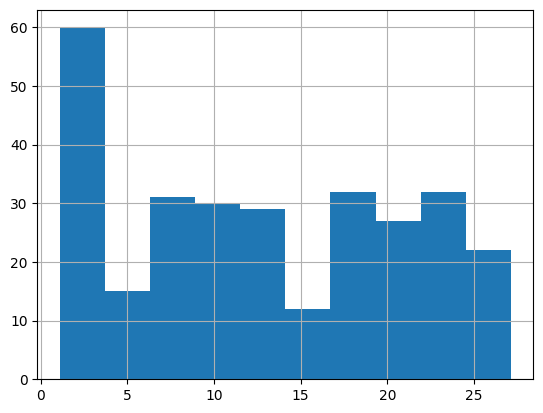

In [42]:
n18['DEPTH (m)'].hist()

In [79]:
n18_deep = n18[(n18['TA in (mmol/kgSW)'].notnull()) & (n18['DEPTH (m)'] > 19)]
n18_shallow = n18[(n18['TA in (mmol/kgSW)'].notnull()) & (n18['DEPTH (m)'] < 10)]

deep_dates = n18_deep['PROF_DATE_TIME_LOCAL'].values
deep_tas = n18_deep['TA in (mmol/kgSW)'].values

shallow_dates = n18_shallow['PROF_DATE_TIME_LOCAL'].values
shallow_tas = n18_shallow['TA in (mmol/kgSW)'].values

In [80]:
val_x = n18_shallow
dates = shallow_dates
tas = shallow_tas

#val_x = n18_deep
#dates = deep_dates
#tas = deep_tas

## Load model trained to 6 Loss

In [43]:
model = ExactGPModel(train_x, train_y, likelihood)
model.load_state_dict(torch.load('6Loss.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [81]:
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.from_numpy(val_x[['LATITUDE', 'LONGITUDE', 'year', 'month', 'day', 'DEPTH (m)']].values).float()
    observed_pred = likelihood(model(test_x))

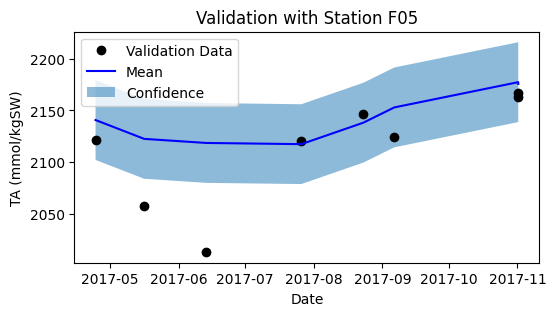

In [82]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(6, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()

    # Plot training data as black stars
    ax.plot(dates, tas, 'ko')

    # Max date
    max_date = dates.max()

    # Min date
    min_date = dates.min()

    # Date for every day in the range
    dates2 = np.arange(min_date, max_date, dtype='datetime64[D]')
    dates2 = dates.astype('datetime64[ns]')
    
    # Plot predictive means as blue line
    ax.plot(dates, observed_pred.mean.numpy(), 'b')

    # Shade between the lower and upper confidence bounds
    ax.fill_between(dates, lower.numpy(), upper.numpy(), alpha=0.5)

    # Set x axis label
    ax.set_xlabel('Date')

    # Set y axis label
    ax.set_ylabel('TA (mmol/kgSW)')

    ax.legend(['Validation Data', 'Mean', 'Confidence'])

    # Title
    ax.set_title('Validation with Station F05')

### Note: may contain lab duplicates